In [69]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt

In [70]:
BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
video_file = BasePath + "Data/multipleTags.mp4"
cap = cv2.VideoCapture(video_file)
frames = []

In [71]:
while(True):
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    frames.append(frame)
    cv2.imshow('frame',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Stream ended..


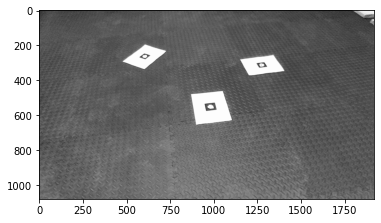

In [72]:
index = 1
image = frames[index]
image_color = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image,  cmap='gray')

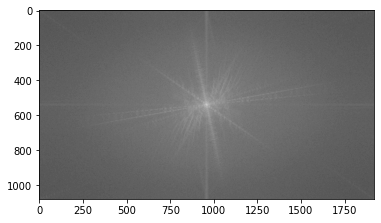

In [73]:
fft = scipy.fft.fft2(image, axes = (0,1))
fft_shifted = scipy.fft.fftshift(fft)
magnitude_spectrum = 20*np.log(np.abs(fft_shifted))
plt.imshow(magnitude_spectrum,  cmap='gray')

In [74]:
def createCircularMask(image_size, radius, high_pass = True):
    rows, cols = image_size
    centre_x, centre_y = int(rows / 2), int(cols / 2)
    center = [centre_x, centre_y]
    x, y = np.ogrid[:rows, :cols]
    mask_area = (x - center[0]) ** 2 + (y - center[1]) ** 2 <= radius*radius

    if high_pass:
        mask = np.ones((rows, cols)) 
        mask[mask_area] = 0
    else:
        mask = np.zeros((rows, cols)) 
        mask[mask_area] = 1

    return mask

In [75]:
def createGaussianMask(image_size, sigma_x, sigma_y):
    cols, rows = image_size
    centre_x, centre_y = rows / 2, cols / 2
    x = np.linspace(0, rows, rows)
    y = np.linspace(0, cols, cols)
    X, Y = np.meshgrid(x,y)
    mask = np.exp(-(np.square((X - centre_x)/sigma_x) + np.square((Y - centre_y)/sigma_y)))
    return mask
    

In [85]:
def findContour(image):
    ret,thresh = cv2.threshold(np.uint8(image), 200 ,255,cv2.THRESH_BINARY)
    plt.imshow(thresh)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chosen_contours = []
    # print(hierarchy)
    for j in range(len(contours)):
        if hierarchy[0, j, 3] == -1:#no parent
            if hierarchy[0, j, 2] !=-1: #child
                print("no parent, child present")
                chosen_contours.append(contours[j])

    return chosen_contours  

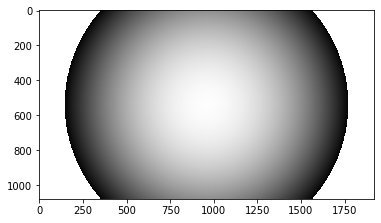

In [86]:
fft_gmasked = fft_shifted * createGaussianMask(image.shape, 30, 30)
magnitude_spectrum = 20*np.log(np.abs(fft_gmasked))
plt.imshow(magnitude_spectrum,  cmap='gray')


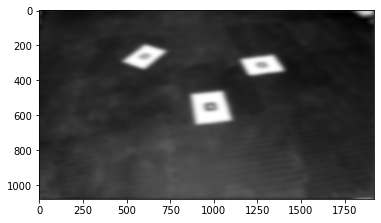

In [87]:
img_back = scipy.fft.ifftshift(fft_gmasked)
img_back = scipy.fft.ifft2(img_back)
img_back = np.abs(img_back)
plt.imshow(img_back, cmap='gray')

no parent, child present
no parent, child present
no parent, child present


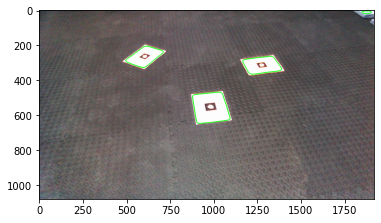

In [88]:
chosen_contours = findContour(img_back)
cv2.drawContours(image_color, chosen_contours, -1, (0,255,0), 3)
plt.imshow(image_color)

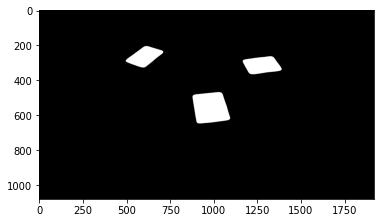

In [89]:
out_mask = np.zeros_like(image)
cv2.drawContours(out_mask, chosen_contours, -1, 1, cv2.FILLED)    
plt.imshow(out_mask, cmap = 'gray')

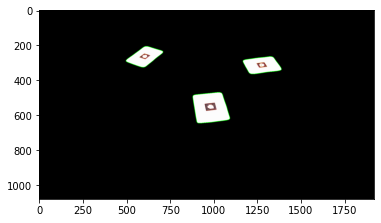

In [90]:
out_mask = np.dstack((out_mask, out_mask, out_mask))
detected_april_tag = image_color * out_mask
plt.imshow(detected_april_tag, cmap = 'gray')
cv2.imshow("c", detected_april_tag)
cv2.waitKey() 
cv2.destroyAllWindows()